## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

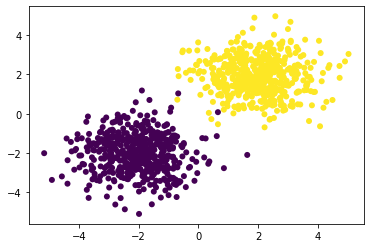

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
print(criterion)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax

ClassNLLCriterion


In [5]:
net = Sequential()
net.add(Linear(2, 6))

net.add(ReLU())
net.add(Linear(6, 4))

net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 6
ReLU
Linear 6 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 100

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
        #print("generator")
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

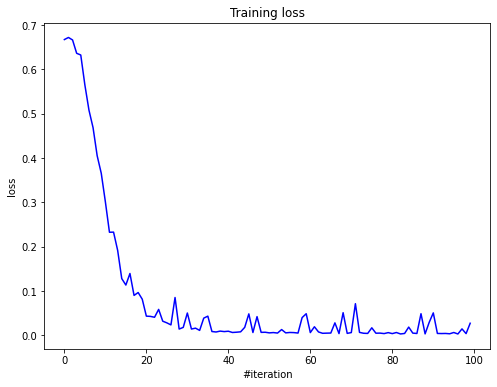

Current loss: 0.027273


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()


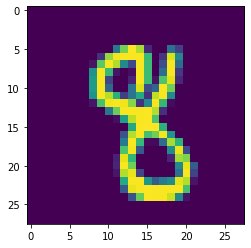

In [10]:
plt.imshow(X_train[-1])


In [11]:
%run modules.ipynb

One-hot encode the labels first.

In [12]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
from sklearn.metrics import accuracy_score
def get_accuracy(predictions):
    pred = np.zeros_like(predictions, 'int')
    j = 0
    for i in predictions:
        pred[j][np.argmax(i)] = 1
        j += 1
    return accuracy_score(y_test, pred)*100

In [14]:
def run_network(net, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history):
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            #print(predictions)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
     

## ReLU

In [15]:
net1 = Sequential()
net1.add(Flatten())
net1.add(Linear(28*28, 300))
net1.add(ReLU())
net1.add(Linear(300, 100))
net1.add(ReLU())
net1.add(Linear(100, 10))
#net1.add(ReLU())
#net1.add(Linear(50, 10))
net1.add(LogSoftMax())
print(net1)

criterion = ClassNLLCriterion()

Flatten
Linear 784 -> 300
ReLU
Linear 300 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



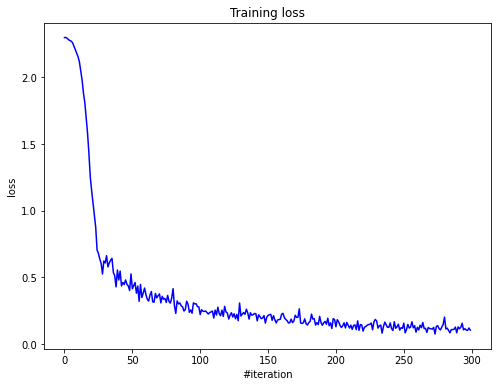

Current loss: 0.105051
CPU times: user 14 s, sys: 958 ms, total: 15 s
Wall time: 8 s


In [16]:
%%time
# Your code goes here. ################################################
loss_history_ReLU = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net1, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_ReLU)

In [17]:
print("Accuracy: ",get_accuracy(net1.forward(X_test)), "%") 

Accuracy:  96.47 %


## ReLU + BatchNorm

In [45]:
net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(28*28, 300))
net2.add(BatchNormalization(0.5))
net2.add(ChannelwiseScaling(300))
net2.add(ReLU())
net2.add(Linear(300, 100))
net2.add(BatchNormalization(0.5))
net2.add(ChannelwiseScaling(100))
net2.add(ReLU())
net2.add(Linear(100, 10))
net2.add(LogSoftMax())
print(net2)

Flatten
Linear 784 -> 300
BatchNormalization
ChannelwiseScaling
ReLU
Linear 300 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



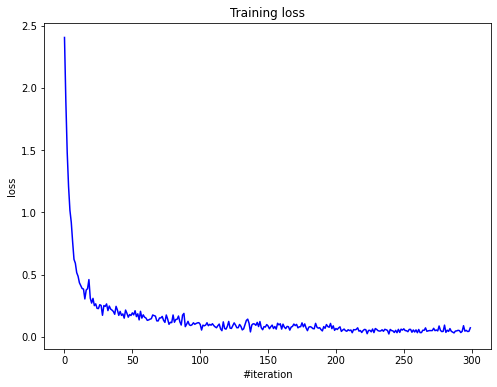

Current loss: 0.073386
CPU times: user 20.7 s, sys: 2.16 s, total: 22.9 s
Wall time: 12.8 s


In [46]:
%%time
loss_history_ReLU_batchnorm = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net2, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_ReLU_batchnorm)


In [47]:
print("Accuracy: ",get_accuracy(net2.forward(X_test)), "%") 

Accuracy:  97.69 %


## ELU 

In [48]:
net3 = Sequential()
net3.add(Flatten())
net3.add(Linear(28*28, 300))
net3.add(ELU())
net3.add(Linear(300, 100))
net3.add(ELU())
net3.add(Linear(100, 10))
net3.add(LogSoftMax())
print(net3)

Flatten
Linear 784 -> 300
ELU
Linear 300 -> 100
ELU
Linear 100 -> 10
LogSoftMax



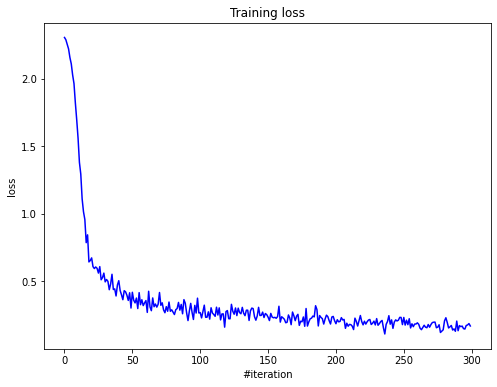

Current loss: 0.170732
CPU times: user 20.1 s, sys: 1.53 s, total: 21.6 s
Wall time: 13.1 s


In [49]:
%%time
loss_history_ELU = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net3, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_ELU)   

In [50]:
print("Accuracy: ",get_accuracy(net3.forward(X_test)), "%") 

Accuracy:  95.33 %


## ELU + BatchNorm

In [51]:
net4 = Sequential()
net4.add(Flatten())
net4.add(Linear(28*28, 300))
net4.add(BatchNormalization(0.5))
net4.add(ChannelwiseScaling(300))
net4.add(ELU())
net4.add(Linear(300, 100))
net4.add(BatchNormalization(0.5))
net4.add(ChannelwiseScaling(100))
net4.add(ELU())
net4.add(Linear(100, 10))
net4.add(LogSoftMax())
print(net4)

Flatten
Linear 784 -> 300
BatchNormalization
ChannelwiseScaling
ELU
Linear 300 -> 100
BatchNormalization
ChannelwiseScaling
ELU
Linear 100 -> 10
LogSoftMax



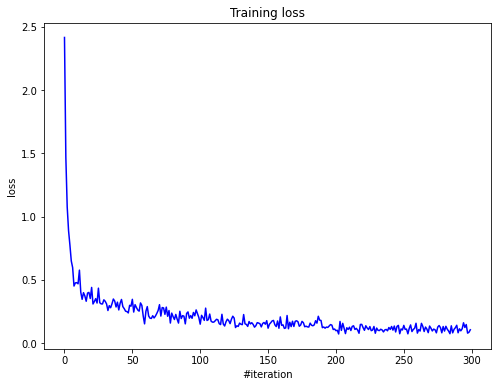

Current loss: 0.105193
CPU times: user 25.4 s, sys: 2.05 s, total: 27.4 s
Wall time: 15.9 s


In [52]:
%%time
loss_history_ELU_batchnorm = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net4, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_ELU_batchnorm)   

In [53]:
print("Accuracy: ",get_accuracy(net4.forward(X_test)), "%") 

Accuracy:  96.67999999999999 %


## LeakyReLU

In [54]:
net5 = Sequential()
net5.add(Flatten())
net5.add(Linear(28*28, 300))
net5.add(LeakyReLU())
net5.add(Linear(300, 100))
net5.add(LeakyReLU())
net5.add(Linear(100, 10))
net5.add(LogSoftMax())
print(net5)

Flatten
Linear 784 -> 300
LeakyReLU
Linear 300 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax



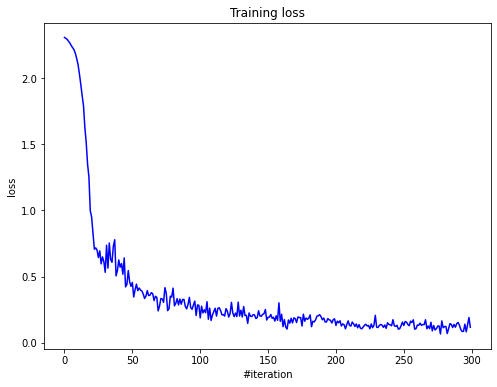

Current loss: 0.117510
CPU times: user 18.3 s, sys: 1.31 s, total: 19.6 s
Wall time: 11.3 s


In [55]:
%%time
loss_history_LeakyReLU = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net5, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_LeakyReLU)   

In [56]:
print("Accuracy: ",get_accuracy(net5.forward(X_test)), "%") 

Accuracy:  96.35000000000001 %


## LeakyReLU + BatchNorm

In [57]:
net6 = Sequential()
net6.add(Flatten())
net6.add(Linear(28*28, 300))
net6.add(BatchNormalization(0.5))
net6.add(ChannelwiseScaling(300))
net6.add(LeakyReLU())
net6.add(Linear(300, 100))
net6.add(BatchNormalization(0.5))
net6.add(ChannelwiseScaling(100))
net6.add(LeakyReLU())
net6.add(Linear(100, 10))
net6.add(LogSoftMax())
print(net6)

Flatten
Linear 784 -> 300
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 300 -> 100
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 100 -> 10
LogSoftMax



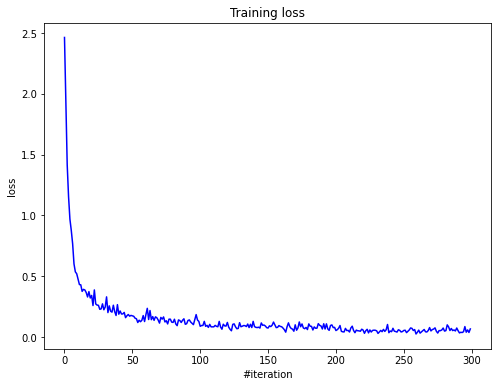

Current loss: 0.066402
CPU times: user 22.9 s, sys: 2.36 s, total: 25.2 s
Wall time: 14.5 s


In [58]:
%%time
loss_history_LeakyReLU_batchnorm = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net6, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_LeakyReLU_batchnorm) 

In [59]:
print("Accuracy: ",get_accuracy(net6.forward(X_test)), "%") 

Accuracy:  97.72 %


## SoftPlus

In [60]:
net7 = Sequential()
net7.add(Flatten())
net7.add(Linear(28*28, 300))
net7.add(SoftPlus())
net7.add(Linear(300, 100))
net7.add(SoftPlus())
net7.add(Linear(100, 10))
net7.add(LogSoftMax())
print(net7)

Flatten
Linear 784 -> 300
SoftPlus
Linear 300 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax



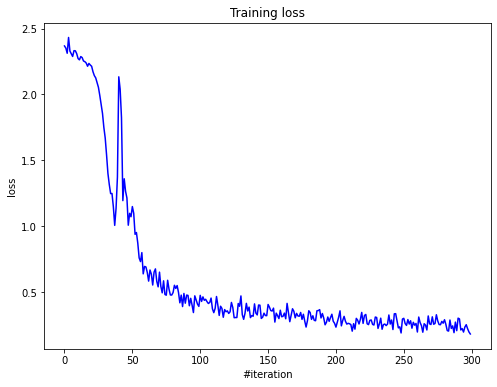

Current loss: 0.181109
CPU times: user 19.9 s, sys: 1.52 s, total: 21.4 s
Wall time: 18.5 s


In [61]:
%%time
loss_history_SoftPlus = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net7, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_SoftPlus)   

In [62]:
print("Accuracy: ",get_accuracy(net7.forward(X_test)), "%") 

Accuracy:  93.2 %


## SoftPlus + BatchNorm

In [63]:
net8 = Sequential()
net8.add(Flatten())
net8.add(Linear(28*28, 300))
net8.add(BatchNormalization(0.5))
net8.add(ChannelwiseScaling(300))
net8.add(SoftPlus())
net8.add(Linear(300, 100))
net8.add(BatchNormalization(0.5))
net8.add(ChannelwiseScaling(100))
net8.add(SoftPlus())
net8.add(Linear(100, 10))
net8.add(LogSoftMax())
print(net8)

Flatten
Linear 784 -> 300
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 300 -> 100
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 100 -> 10
LogSoftMax



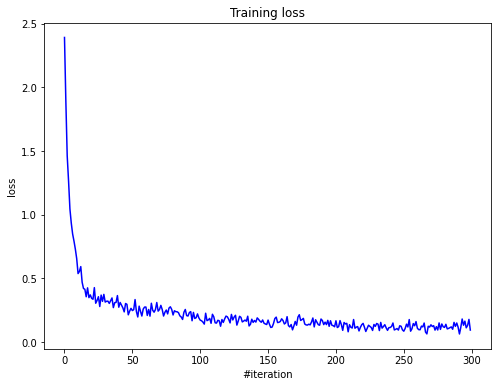

Current loss: 0.094956
CPU times: user 23.6 s, sys: 2.08 s, total: 25.7 s
Wall time: 16.8 s


In [64]:
%%time
loss_history_SoftPlus_batchnorm = []
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 3
batch_size = 500

run_network(net8, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_SoftPlus_batchnorm)     

In [65]:
print("Accuracy: ",get_accuracy(net8.forward(X_test)), "%") 

Accuracy:  96.41999999999999 %


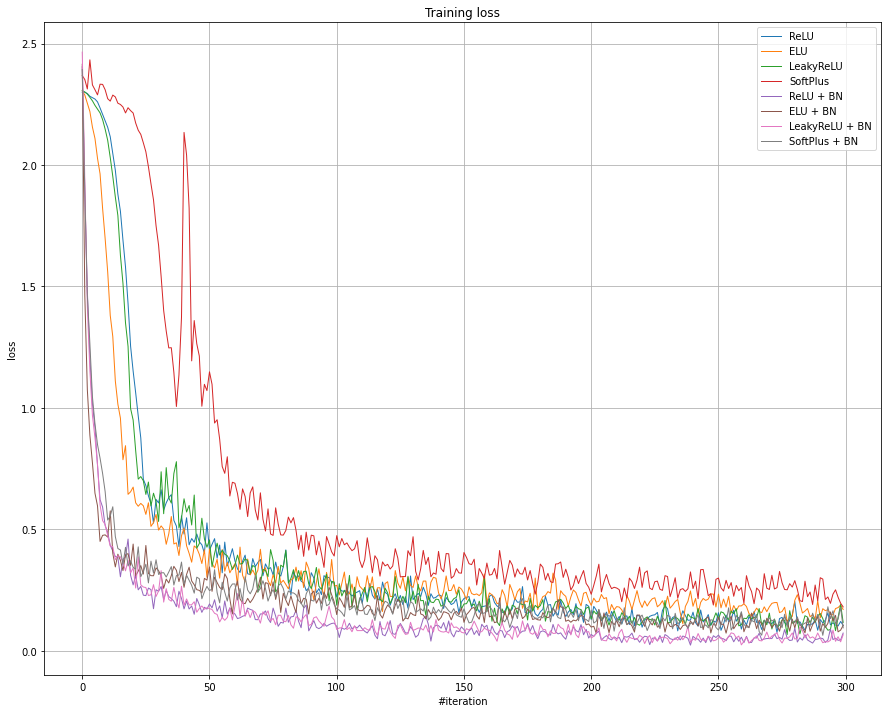

In [66]:
plt.figure(figsize=(15, 12))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_ReLU, label = 'ReLU', lw=1)
plt.plot(loss_history_ELU, label = 'ELU', lw=1)
plt.plot(loss_history_LeakyReLU, label = 'LeakyReLU', lw=1)
plt.plot(loss_history_SoftPlus, label = 'SoftPlus', lw=1)

plt.plot(loss_history_ReLU_batchnorm,  label = 'ReLU + BN', lw=1)
plt.plot(loss_history_ELU_batchnorm, label = 'ELU + BN', lw=1)
plt.plot(loss_history_LeakyReLU_batchnorm, label = 'LeakyReLU + BN', lw=1)
plt.plot(loss_history_SoftPlus_batchnorm, label = 'SoftPlus + BN', lw=1)
plt.legend()
plt.grid(True)
plt.show()

- Попробуем взять логарифм от loss, чтобы лучше было видно разницу между кривыми.

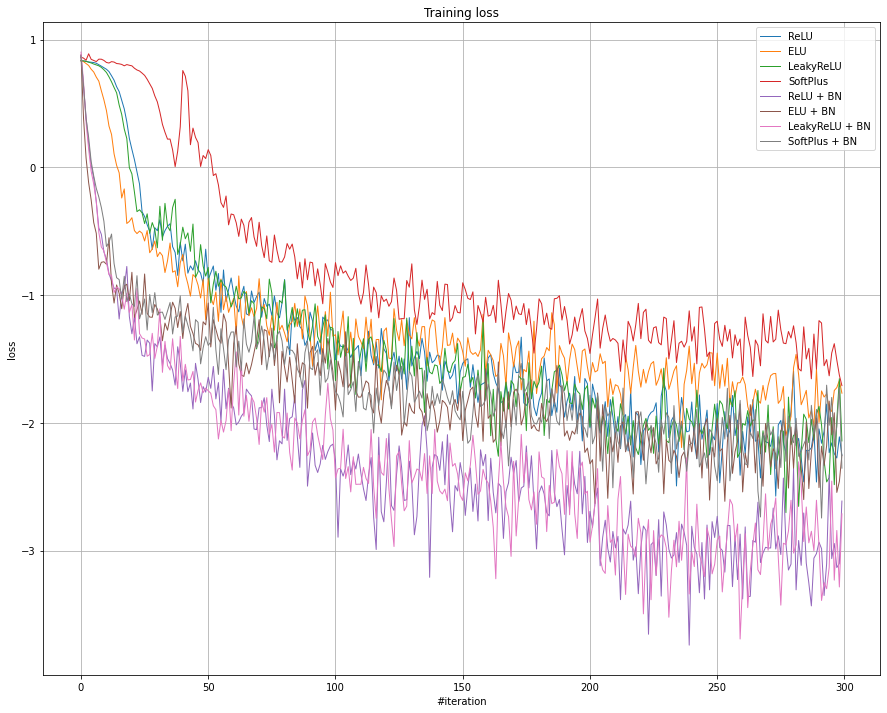

In [67]:
plt.figure(figsize=(15, 12))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(np.log(loss_history_ReLU), label = 'ReLU', lw=1)
plt.plot(np.log(loss_history_ELU), label = 'ELU', lw=1)
plt.plot(np.log(loss_history_LeakyReLU), label = 'LeakyReLU', lw=1)
plt.plot(np.log(loss_history_SoftPlus), label = 'SoftPlus', lw=1)

plt.plot(np.log(loss_history_ReLU_batchnorm),  label = 'ReLU + BN', lw=1)
plt.plot(np.log(loss_history_ELU_batchnorm), label = 'ELU + BN', lw=1)
plt.plot(np.log(loss_history_LeakyReLU_batchnorm), label = 'LeakyReLU + BN', lw=1)
plt.plot(np.log(loss_history_SoftPlus_batchnorm), label = 'SoftPlus + BN', lw=1)
plt.legend()
plt.grid(True)
plt.show()

### Вывод
В дальнейшем буду использовать ReLU, потому что она показала себя на метриках и по времени лучше всех остальных.

### Замечание
- По графикам и по значениям accuracy можно сделать вывод, что лучше всего справляется ReLu и LeakyReLU.
- Сетки с BatchNormalization показывают себя лучше, особенно хорошо это видно если мы посмотрим loss на первых 50 иттераций.
- SoftPlus показала себя хуже всех. По времени она также работала дольше всех, ведь для ее расчета нужно считать значение экспоненты и логарифма, что дорого в смысле вычислительной мощности.

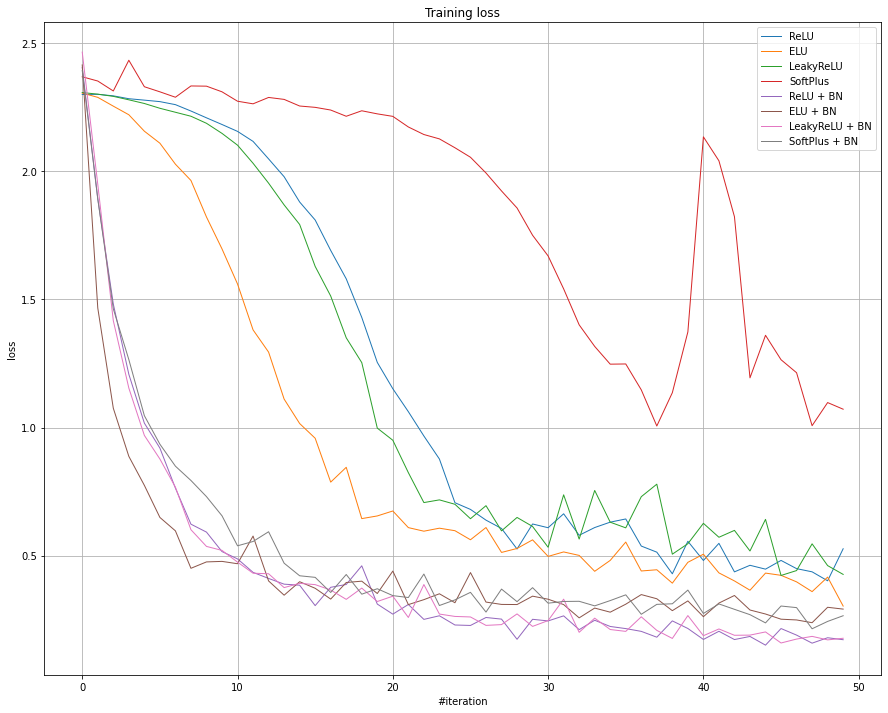

In [68]:
plt.figure(figsize=(15, 12))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_ReLU[:50], label = 'ReLU', lw=1)
plt.plot(loss_history_ELU[:50], label = 'ELU', lw=1)
plt.plot(loss_history_LeakyReLU[:50], label = 'LeakyReLU', lw=1)
plt.plot(loss_history_SoftPlus[:50], label = 'SoftPlus', lw=1)

plt.plot(loss_history_ReLU_batchnorm[:50],  label = 'ReLU + BN', lw=1)
plt.plot(loss_history_ELU_batchnorm[:50], label = 'ELU + BN', lw=1)
plt.plot(loss_history_LeakyReLU_batchnorm[:50], label = 'LeakyReLU + BN', lw=1)
plt.plot(loss_history_SoftPlus_batchnorm[:50], label = 'SoftPlus + BN', lw=1)
plt.legend()
plt.grid(True)
plt.show()

## Adam

In [70]:
net = Sequential()
net.add(Flatten())
net.add(Linear(28*28, 300))
net.add(BatchNormalization(0.5))
net.add(ChannelwiseScaling(300))
net.add(ReLU())
net.add(Linear(300, 100))
net.add(BatchNormalization(0.5))
net.add(ChannelwiseScaling(100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(LogSoftMax())


net_ = Sequential()
net_.add(Flatten())
net_.add(Linear(28*28, 300))
net_.add(BatchNormalization(0.5))
net_.add(ChannelwiseScaling(300))
net_.add(ReLU())
net_.add(Linear(300, 100))
net_.add(BatchNormalization(0.5))
net_.add(ChannelwiseScaling(100))
net_.add(ReLU())
net_.add(Linear(100, 10))
net_.add(LogSoftMax())


- Возьмем learning_rate=1e-3, чтобы оценить всю силу оптимизации Adam.

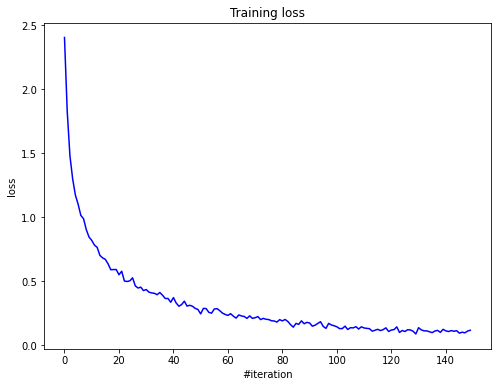

Current loss: 0.115834
CPU times: user 21.2 s, sys: 3.54 s, total: 24.7 s
Wall time: 14 s


In [71]:
%%time
loss_history_Adam = []
optimizer_config = {'learning_rate' : 1e-3, 'beta1' : 0.9, 'beta2' : 0.999, 'epsilon' : 1e-8}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 1000

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_Adam.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_Adam, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    
    
 

In [72]:
print("Accuracy: ",get_accuracy(net.forward(X_test)), "%") 

Accuracy:  97.43 %


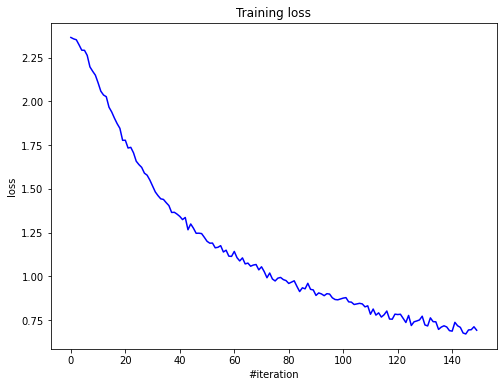

Current loss: 0.691272
CPU times: user 21.7 s, sys: 3.28 s, total: 25 s
Wall time: 15.4 s


In [73]:
%%time
loss_history_sgd_momentum = []
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
n_epoch = 3
batch_size = 1000

run_network(net_, n_epoch, batch_size, optimizer_config, optimizer_state, loss_history_sgd_momentum)   
  

In [75]:
print("Accuracy: ",get_accuracy(net_.forward(X_test)), "%") 

Accuracy:  88.83 %


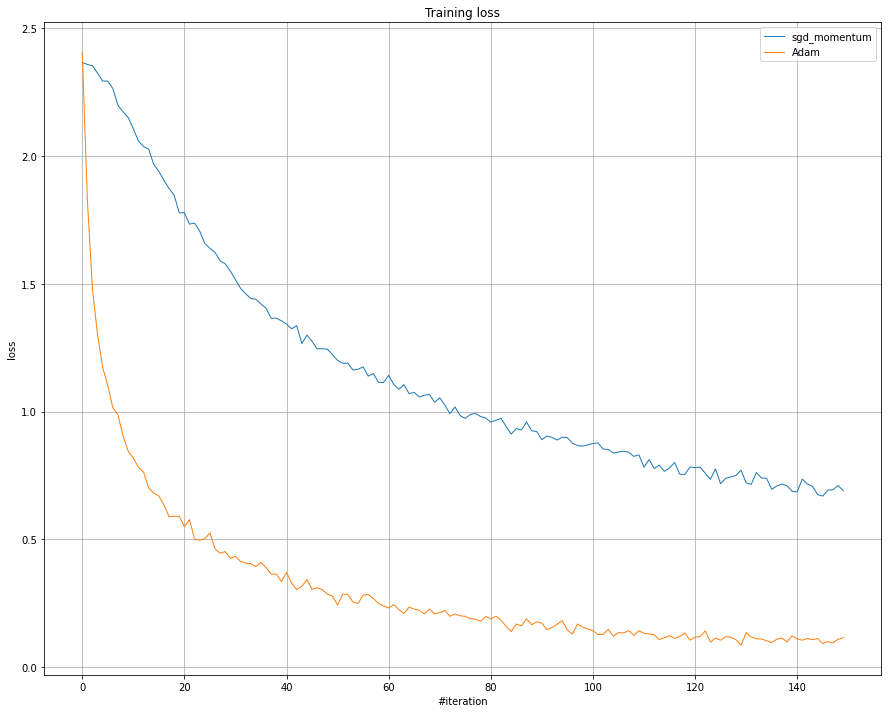

In [74]:
plt.figure(figsize=(15, 12))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")

plt.plot(loss_history_sgd_momentum,  label = 'sgd_momentum', lw=1)
plt.plot(loss_history_Adam,  label = 'Adam', lw=1)
plt.legend()
plt.grid(True)
plt.show()

- На графике хорошо видно насколько Adam сходится быстрее, чем Momentum

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

- Построил более глубокую сетку, используя ReLU и BatchNorm, тк выше они показали лучшие результаты. 
- Аугментация данных для такого большого датасета бесполезна. 
- Что касается Dropout, его я не использую по причине того, что модель не переобучается. 
- Также пользуюсь Adam optimization.

In [76]:
network = Sequential()
network.add(Flatten())
network.add(Linear(28*28, 500))
network.add(BatchNormalization(0.5))
network.add(ChannelwiseScaling(500))
#network.add(Dropout())
network.add(ReLU())
network.add(Linear(500, 400))
network.add(BatchNormalization(0.5))
network.add(ChannelwiseScaling(400))
#network.add(Dropout())
network.add(ReLU())
network.add(Linear(400, 300))
network.add(BatchNormalization(0.5))
network.add(ChannelwiseScaling(300))
#network.add(Dropout())
network.add(ReLU())
network.add(Linear(300, 200))
network.add(BatchNormalization(0.5))
network.add(ChannelwiseScaling(200))
#network.add(Dropout())
network.add(ReLU())
network.add(Linear(200, 100))
network.add(BatchNormalization(0.5))
network.add(ChannelwiseScaling(100))
#network.add(Dropout())
network.add(ReLU())
network.add(Linear(100, 10))
network.add(LogSoftMax())



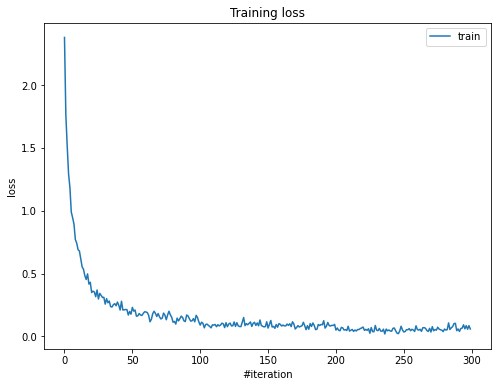

Current loss train: 0.058824


In [1354]:
loss_history = []
#loss_test = []
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1' : 0.9, 'beta2' : 0.999, 'epsilon' : 1e-8}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 500

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        network.zeroGradParameters()
        # Forward
        predictions = network.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward
        dp = criterion.backward(predictions, y_batch)
        network.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(network.getParameters(), 
                     network.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
        #pred = network.forward(X_test)
        #loss_t = criterion.forward(pred, y_test)
        #loss_test.append(loss_t)
        
    # Visualize
    
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, label = 'train')
    #plt.plot(loss_test, label = 'test')
    plt.legend()
    plt.show()
    
    
    print('Current loss train: %f' % loss)    
    #print('Current loss test: %f' % loss_t)    

In [1355]:
print("Accuracy: ",get_accuracy(network.forward(X_test)), "%") 

Accuracy:  97.57000000000001 %


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [1356]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [1357]:
# Your beautiful code here.

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax() 
        )
        
    def forward(self, inp): 
        out = self.model(inp)
        return out

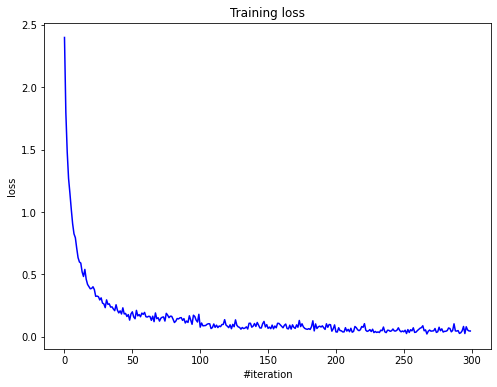

Current loss: 0.046377


In [1358]:
num_epochs = 3
num_classes = 10 
batch_size = 500 
model = NeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
loss_history = []
model.train(True)

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size):
        model.zero_grad()
        # Forward
        predictions = model.forward(x_batch[:, None])
        loss = criterion.forward(predictions, torch.max(y_batch, 1)[1])
    
        # Backward
        #dp = criterion.backward(predictions, y_batch)
        loss.backward()
        
        # Update weights
        optimizer.step()     
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [1359]:
predictions = model.forward((torch.FloatTensor(X_test)))
print("Accuracy: ",get_accuracy(predictions.detach().numpy()), "%") 


Accuracy:  97.65 %


- Получили такой же результат, следовательно написанные функции работают корректно. Можно считать это успехом :)